# Interconnect Telecom
## Reducing Customer Churn with Data-Driven Strategies

**Client:** Interconnect 

**Objective:**  
This notebook presents an end-to-end churn prediction pipeline using customer, contract, and service data from Interconnect, a telecom provider. The goal is to identify customers likely to churn and support proactive retention efforts.

**Business Value:**  
By identifying customers at risk of churning, Interconnect can reduce customer loss, improve retention rates, and increase overall revenue by targeting the right users with offers.

**Target Variable:**  
Churn status — defined by whether the column `EndDate` is equal to `'No'` (i.e., the customer has *not* ended their contract).

**Primary Metric:**  
AUC-ROC — Area Under the Receiver Operating Characteristic Curve. This will be the main metric used to evaluate model performance.

**Secondary Metric:**  
Accuracy — the percentage of correct predictions.

**Data Sources:**  
The dataset is split into four CSV files:

- `contract.csv` — contract information  
- `personal.csv` — personal client data  
- `internet.csv` — internet service usage and features  
- `phone.csv` — telephone service usage and features  

Each file is joined by a unique identifier: `customerID`.

----------

## Import Libraries and Packages

In [3]:
import pandas as pd  # For data manipulation and DataFrame operations
import seaborn as sns  # For enhanced data visualizations
import matplotlib.pyplot as plt  # For plotting charts and figures

from sklearn.model_selection import train_test_split  # To split data into training and testing sets
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.preprocessing import StandardScaler  # For scaling numerical features
from sklearn.metrics import roc_auc_score, accuracy_score  # To evaluate model performance

from sklearn.ensemble import RandomForestClassifier  # Random Forest model
from sklearn.ensemble import GradientBoostingClassifier  # Gradient Boosting model
from xgboost import XGBClassifier  # XGBoost model 
from lightgbm import LGBMClassifier  # LightGBM model

# Suppress FutureWarnings from pandas and sklearn
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load, Explore and Clean Datasets

## Contract Dataset

In [6]:
# Load the contract data
contract_path = '/Users/mattbaglietto/interconnect/contract.csv'
contract = pd.read_csv(contract_path)

In [7]:
# Display shape and first few rows
print("Contract dataset:", contract.shape)
contract.head()

Contract dataset: (7043, 8)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [8]:
# Get a summary of the dataset
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
# Check for missing values
contract.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [10]:
# Get basic stats on numerical columns
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [11]:
# Check value counts for categorical features
for col in contract.select_dtypes(include='object').columns:
    print(f"\nValue counts for {col}:")
    print(contract[col].value_counts(dropna=False))


Value counts for customerID:
customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: count, Length: 7043, dtype: int64

Value counts for BeginDate:
BeginDate
2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: count, Length: 77, dtype: int64

Value counts for EndDate:
EndDate
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64

Value counts for Type:
Type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

Value counts for PaperlessBilling:
PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64

Value counts for PaymentMethod:
Payment

## Contract Dataset: Initial Observations

### Overview
- The dataset contains 7,043 entries and 8 columns.
- Each row represents a unique customer, identified by `customerID`.

### Columns Summary
- `customerID`: Unique identifier for each customer.
- `BeginDate`: The start date of the customer's contract (string format).
- `EndDate`: The end date of the customer's contract, or 'No' if the customer is still active.
- `Type`: Contract type — 'Month-to-month', 'One year', or 'Two year'.
- `PaperlessBilling`: Indicates whether the customer uses paperless billing ('Yes' or 'No').
- `PaymentMethod`: Method used for payment (e.g., 'Electronic check', 'Mailed check').
- `MonthlyCharges`: Monthly billing amount (numeric).
- `TotalCharges`: Total billing amount (stored as object, should be numeric).

### Key Findings
- `TotalCharges` is incorrectly stored as an object due to some blank entries. This needs to be converted to a numeric type.
- There are 11 missing or blank values in `TotalCharges`, likely due to new customers who haven't been billed yet.
- The `EndDate` column includes 'No' for active customers. This will be used to define the target variable for churn prediction.
- `BeginDate` and `EndDate` are in string format and should be converted to datetime objects for any temporal analysis.
- No missing values are present in other columns.

### Next Steps
1. Convert `TotalCharges` to numeric and handle missing values.
2. Convert `BeginDate` and `EndDate` columns to datetime format.
3. Create a binary `Churn` column using `EndDate`.

In [13]:
# Convert 'BeginDate' from string to datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

In [14]:
# Replace the string 'No' in 'EndDate' with pandas' missing value indicator or proper datetime conversion
contract['EndDate'] = contract['EndDate'].replace('No', pd.NA)

In [15]:
# Replacing 'No' with missing value before parsing
contract['EndDate'] = contract['EndDate'].replace('No', pd.NA)

In [16]:
# Let pandas format automatically
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

In [17]:
# Create binary churn target: 1 if customer has an EndDate, 0 otherwise
contract['Churn'] = contract['EndDate'].notna().astype(int)

In [18]:
# Confirm the data types of the columns
contract[['BeginDate', 'EndDate']].dtypes

BeginDate    datetime64[ns]
EndDate      datetime64[ns]
dtype: object

In [19]:
# Look at a few rows for churned and non-churned customers
contract[['customerID', 'EndDate', 'Churn']].sample(10)

,customerID,EndDate,Churn
4690,7036-ZZKBD,NaT,0
2488,4701-MLJPN,2020-01-01,1
859,5275-PMFUT,NaT,0
4850,0931-MHTEM,NaT,0
2006,0224-HJAPT,2019-10-01,1
669,0214-JHPFW,NaT,0
5262,4560-WQAQW,NaT,0
5173,2480-SQIOB,NaT,0
1631,4248-QPAVC,2019-11-01,1
1268,2408-TZMJL,2019-11-01,1


In [20]:
# Make sure Churn = 1 only where EndDate is present
(contract['Churn'] == contract['EndDate'].notna()).all()

True

## Contract Dataset: Data Cleaning and Preprocessing Summary

### Date Conversion
- Converted the `BeginDate` column from string to `datetime64[ns]` format using the known date format (`%Y-%m-%d`).
- Replaced the value `'No'` in the `EndDate` column with `pd.NA` to mark ongoing (non-churned) customers.
- Converted the cleaned `EndDate` column to `datetime64[ns]` format.

### Target Variable Creation
- Created a new binary column `Churn` to indicate whether a customer has churned.
  - `Churn = 1` if the customer has an `EndDate` (i.e., they churned).
  - `Churn = 0` if the customer is still active (`EndDate` is missing).

### Quality Checks
- Verified that both `BeginDate` and `EndDate` are in proper datetime format.
- Confirmed that the `Churn` column is correctly aligned with the `EndDate` values.
- Displayed the distribution of churned vs. active customers for future reference.

The contract dataset is now cleaned and ready for integration with the other datasets or for further analysis.


## Personal Dataset

In [23]:
# Load the personal dataset
personal_path = '/Users/mattbaglietto/interconnect/personal.csv'
personal = pd.read_csv(personal_path)

In [24]:
# Basic structure
print("Personal dataset:", personal.shape)
personal.head()

Personal dataset: (7043, 5)


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [25]:
# Info on data types and non-null counts
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [26]:
# Check for missing values
personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [27]:
# Display unique values for object (categorical) columns
for col in personal.select_dtypes(include='object').columns:
    print(f"\nValue counts for {col}:")
    print(personal[col].value_counts(dropna=False))


Value counts for customerID:
customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: count, Length: 7043, dtype: int64

Value counts for gender:
gender
Male      3555
Female    3488
Name: count, dtype: int64

Value counts for Partner:
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Value counts for Dependents:
Dependents
No     4933
Yes    2110
Name: count, dtype: int64


## Personal Dataset: Initial Observations and Exploration Summary

### Overview
- The dataset contains 7,043 rows and 5 columns.
- Each row represents a unique customer, identified by `customerID`.

### Columns Summary
- `customerID`: Unique identifier for each customer. All values are unique.
- `gender`: Customer gender, with a near-even distribution between Male and Female.
- `SeniorCitizen`: Binary indicator where 0 = not a senior citizen, 1 = senior citizen.
- `Partner`: Indicates whether the customer has a partner ('Yes' or 'No').
- `Dependents`: Indicates whether the customer has dependents ('Yes' or 'No').

### Key Findings
- No missing values in any column.
- All data types are appropriate for this stage of the analysis.
- Categorical variables such as `Partner` and `Dependents` will be converted to binary format later during preprocessing for modeling.

The dataset is clean and ready to be merged with the others or used in further analysis.

## Internet Dataset

In [30]:
# Load the internet dataset
internet_path = '/Users/mattbaglietto/interconnect/internet.csv'
internet = pd.read_csv(internet_path)

In [31]:
# Basic structure
print("Internet dataset:", internet.shape)
internet.head()

Internet dataset: (5517, 8)


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [32]:
# Data types and non-null counts
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [33]:
# Check for missing values
internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [34]:
# Display unique value counts for all object (categorical) columns
for col in internet.select_dtypes(include='object').columns:
    print(f"\nValue counts for {col}:")
    print(internet[col].value_counts(dropna=False))


Value counts for customerID:
customerID
7590-VHVEG    1
5181-OABFK    1
9356-AXGMP    1
5176-OLSKT    1
7508-DQAKK    1
             ..
1104-FEJAM    1
2972-YDYUW    1
4238-JSSWH    1
0869-PAPRP    1
3186-AJIEK    1
Name: count, Length: 5517, dtype: int64

Value counts for InternetService:
InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

Value counts for OnlineSecurity:
OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int64

Value counts for OnlineBackup:
OnlineBackup
No     3088
Yes    2429
Name: count, dtype: int64

Value counts for DeviceProtection:
DeviceProtection
No     3095
Yes    2422
Name: count, dtype: int64

Value counts for TechSupport:
TechSupport
No     3473
Yes    2044
Name: count, dtype: int64

Value counts for StreamingTV:
StreamingTV
No     2810
Yes    2707
Name: count, dtype: int64

Value counts for StreamingMovies:
StreamingMovies
No     2785
Yes    2732
Name: count, dtype: int64


## Internet Dataset: Data Cleaning and Exploration Summary

### Overview
- The dataset contains 5,517 rows and 8 columns.
- Each row corresponds to a customer with an internet service.
- Customers not listed in this dataset are assumed to not have internet service.

### Columns Summary
- `customerID`: Unique identifier for each customer. All values are unique.
- `InternetService`: Type of internet connection. Options include 'DSL' and 'Fiber optic'.
- `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`: 
  - Binary categorical features indicating whether the customer subscribes to each additional service ('Yes' or 'No').

### Key Findings
- No missing values in any column.
- All listed customers have some form of internet service.
- The dataset has fewer records than other datasets (5,517 vs. 7,043), indicating that some customers do not subscribe to internet service.
- All features are categorical and suitable for encoding during the preprocessing stage.

This dataset is clean and ready to be merged with the others. Special care will be needed to handle customers who do not appear in this dataset during the merge process.

## Phone Dataset

In [37]:
# Load the phone dataset
phone_path = '/Users/mattbaglietto/interconnect/phone.csv'
phone = pd.read_csv(phone_path)

In [38]:
# Basic structure
print("Shape of phone dataset:", phone.shape)
phone.head()

Shape of phone dataset: (6361, 2)


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [39]:
# Check data types and non-null counts
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [40]:
# Check for missing values
phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

In [41]:
# View value counts for categorical columns
for col in phone.select_dtypes(include='object').columns:
    print(f"\nValue counts for {col}:")
    print(phone[col].value_counts(dropna=False))


Value counts for customerID:
customerID
5575-GNVDE    1
0980-FEXWF    1
8082-GHXOP    1
3393-FMZPV    1
8701-DGLVH    1
             ..
8197-BFWVU    1
9154-QDGTH    1
8499-BRXTD    1
8552-OBVRU    1
3186-AJIEK    1
Name: count, Length: 6361, dtype: int64

Value counts for MultipleLines:
MultipleLines
No     3390
Yes    2971
Name: count, dtype: int64


## Phone Dataset: Data Cleaning and Exploration Summary

### Overview
- The dataset contains 6,361 rows and 2 columns.
- Each row corresponds to a customer who subscribes to a phone service.

### Columns Summary
- `customerID`: Unique identifier for each customer. All values are unique and non-null.
- `MultipleLines`: Indicates whether the customer has multiple phone lines ('Yes' or 'No').

### Key Findings
- No missing values in the dataset.
- The dataset includes only customers with phone service; those not listed are assumed to not have phone service.
- All values are categorical and suitable for encoding during the preprocessing stage.

The dataset is clean and will require appropriate handling of customers without phone service during the merge process.


<Axes: title={'center': 'Distribution of Contract Types'}, xlabel='Type'>

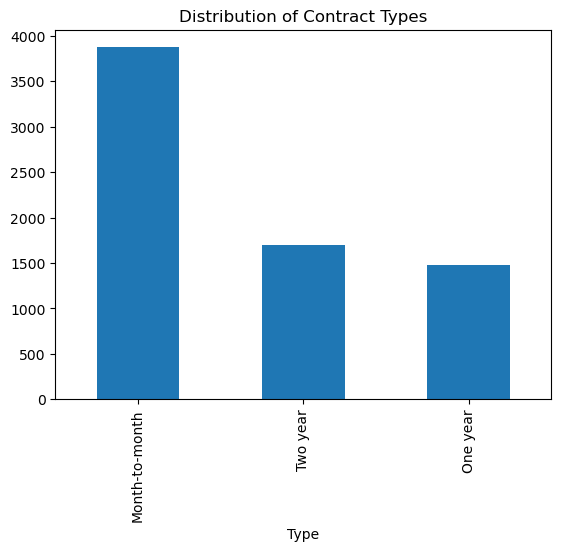

In [43]:
# Distribution of Contract Types Bar Plot
contract['Type'].value_counts().plot(kind='bar', title='Distribution of Contract Types')

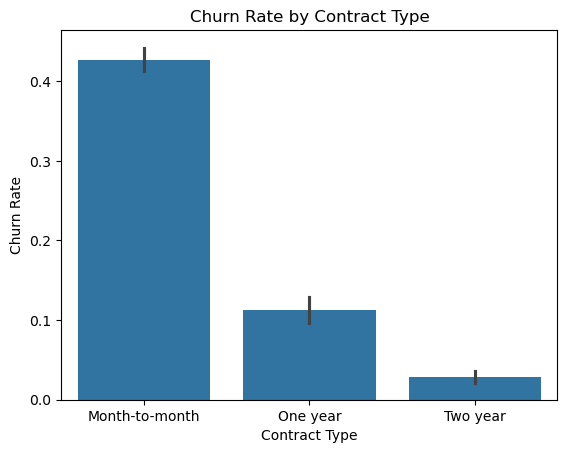

In [44]:
# Distribution of Churn Rate by Contract Type Bar Plot
sns.barplot(data=contract, x='Type', y='Churn')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Rate')
plt.xlabel('Contract Type')
plt.show()

<Axes: title={'center': 'Distribution of Monthly Charges'}, ylabel='Frequency'>

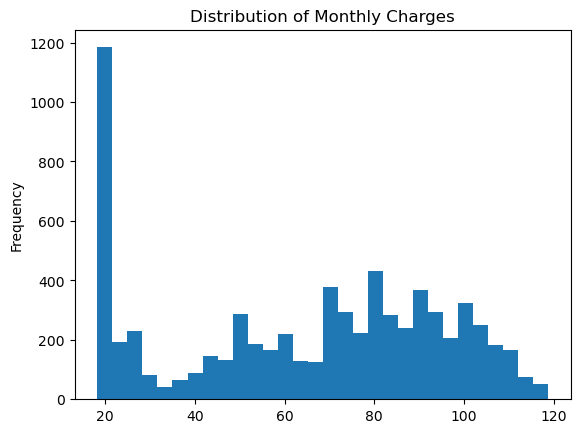

In [45]:
# Distribution of Monthly Charges Bar Plot
contract['MonthlyCharges'].plot(kind='hist', bins=30, title='Distribution of Monthly Charges')

<Axes: title={'center': 'Internet Service Type Distribution'}, ylabel='count'>

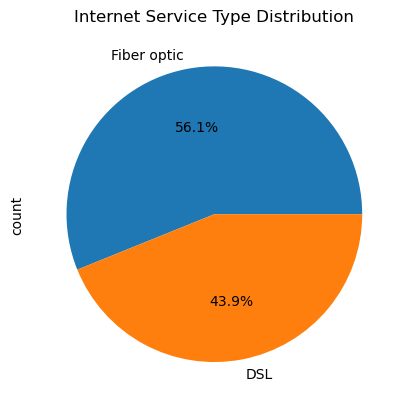

In [46]:
# Internet Service By Type Pie Graph
internet['InternetService'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Internet Service Type Distribution')

## Visual Exploration Summary

To supplement the initial EDA, a few key visualizations were generated to better understand the distribution of service types and their relationship to churn.

### 1. Distribution of Contract Types
The majority of customers are on month-to-month contracts, followed by two-year and one-year contracts. This is useful context for understanding churn behavior, as shorter-term contracts may reflect less commitment.

### 2. Churn Rate by Contract Type
The churn rate is significantly higher for month-to-month contracts compared to one- and two-year contracts. Customers with longer commitments are less likely to churn, which suggests contract length is a strong predictor of churn.

### 3. Distribution of Monthly Charges
Monthly charges show a wide spread, with a noticeable spike at the low end (~$20). This could reflect customers with minimal services or introductory pricing. Understanding this distribution helps frame how cost may relate to churn or service combinations.

### 4. Internet Service Type Distribution
Among customers with internet service, the majority use fiber optic connections, followed by DSL. This split may have implications for churn or for the effectiveness of bundled services.

These visual patterns provide early insight into customer behavior and potential churn predictors. More detailed correlations will be explored after merging datasets.

## Merge Datasets

In [49]:
# Start with the contract dataset (base)
df_merged = contract.copy()

In [50]:
# Merge with personal dataset
df_merged = df_merged.merge(personal, on='customerID', how='left')

In [51]:
# Merge with internet dataset (left join, keep all customers)
df_merged = df_merged.merge(internet, on='customerID', how='left')

In [52]:
# Merge with phone dataset (left join, keep all customers)
df_merged = df_merged.merge(phone, on='customerID', how='left')

In [53]:
# Replace blank spaces and convert to float in 'TotalCharges'
df_merged['TotalCharges'] = df_merged['TotalCharges'].replace(' ', pd.NA)
df_merged['TotalCharges'] = pd.to_numeric(df_merged['TotalCharges'])
df_merged['TotalCharges'] = df_merged['TotalCharges'].fillna(0)

In [54]:
# Check shape and preview
print("Merged dataset:", df_merged.shape)
df_merged.head()

Merged dataset: (7043, 21)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [55]:
# Check for missing values
df_merged.isnull().sum()

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [56]:
# Make sure no duplicates were introduced
df_merged['customerID'].nunique()

7043

In [57]:
# Validate all IDs from contract are in merged set
set(contract['customerID']) == set(df_merged['customerID'])

True

## Dataset Merge Summary

All four datasets were successfully merged into a single unified dataframe using `customerID` as the common key.

### Merge Details
- **Base dataset:** `contract` (contains churn target and billing information)
- Merged with:
  - `personal` using a left join — all 7,043 customers matched
  - `internet` using a left join — 5,517 customers had internet service
  - `phone` using a left join — 6,361 customers had phone service

### Validation
- All 7,043 customers from the `contract` dataset are present in the merged dataset
- All customer IDs from the `personal`, `internet`, and `phone` datasets that existed in the `contract` dataset were successfully merged
- No duplicates or unmatched entries were introduced

### Resulting Dataset
- **Shape:** 7,043 rows × 21 columns
- Missing values exist only in service-related columns for customers who do not subscribe to internet or phone services

### Next Step
Missing values in service-related columns will be filled with `'No'` to reflect that the customer does not use those services. This prepares the dataset for feature engineering and model development.

In [59]:
# Define columns related to internet and phone services
internet_cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
phone_cols = ['MultipleLines']

In [60]:
# Fill missing values with 'No' to indicate the customer doesn't have the service
df_merged[internet_cols] = df_merged[internet_cols].fillna('No')
df_merged[phone_cols] = df_merged[phone_cols].fillna('No')

In [61]:
# Make sure no missing values remain
df_merged.isnull().sum()

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
MultipleLines          0
dtype: int64

## Missing Value Cleanup Summary

After merging all four datasets, service-related columns contained missing values for customers who do not subscribe to internet or phone services. These values were handled as follows:

### Cleanup Actions
- Filled missing values in internet service columns (`InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`) with `'No'`
- Filled missing values in `MultipleLines` (phone service) with `'No'`

### Result
- All missing values have been successfully handled
- The only remaining null values are in the `EndDate` column, which are used intentionally to identify non-churned customers
- The dataset is now fully cleaned and ready for feature engineering and modeling

----------

## Work Plan: Feature Engineering and Modeling

With the dataset fully merged and cleaned, the next steps will focus on preparing the data for modeling and building a churn prediction model.

### Step 1: Feature Engineering
- Convert categorical variables (e.g., `Yes`/`No`, `gender`, `PaymentMethod`, etc.) into numerical format using one-hot encoding or label encoding
- Create any helpful derived features, such as `Tenure` from `BeginDate` to represent how long a customer has been active

### Step 2: Data Splitting
- Split the data into features (`X`) and target (`y`)
- Perform a train/test split (e.g., 80/20) to evaluate model performance on unseen data

### Step 3: Model Training
- Train baseline models such as Logistic Regression, Random Forest, and Gradient Boosting
- Use cross-validation to assess model robustness

### Step 4: Model Evaluation
- Evaluate models using AUC-ROC as the primary metric and Accuracy as a secondary metric
- Compare models to identify the best-performing one

### Step 5: Finalization and Reporting
- Select the best model and save relevant outputs
- Summarize findings, key features, and performance
- Prepare a report and finalize the notebook for submission

----------

## Step 1: Feature Engineering

In [65]:
# Redefine Yes/No columns
yes_no_cols = ['PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [66]:
# Replace 'Yes'/'No' with 1/0
df_merged[yes_no_cols] = df_merged[yes_no_cols].replace({'Yes': 1, 'No': 0})

In [67]:
# Convert to integers to remove the warning
df_merged[yes_no_cols] = df_merged[yes_no_cols].astype(int)

In [68]:
# Force proper type conversion
df_merged[yes_no_cols] = df_merged[yes_no_cols].astype(int)

In [69]:
# Calculate tenure in months
df_merged['Tenure'] = (pd.to_datetime('2020-02-01') - df_merged['BeginDate']) / pd.Timedelta(days=30)
df_merged['Tenure'] = df_merged['Tenure'].round().astype(int)

In [70]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_merged, columns=['Type', 'PaymentMethod', 'InternetService', 'gender'], drop_first=True)

In [71]:
# Drop non-useful columns
df_encoded = df_encoded.drop(columns=['customerID', 'BeginDate', 'EndDate'])

In [72]:
# Confirm unique values for each binary column
for col in yes_no_cols:
    print(f"{col} unique values: {df_merged[col].unique()}")

PaperlessBilling unique values: [1 0]
Partner unique values: [1 0]
Dependents unique values: [0 1]
OnlineSecurity unique values: [0 1]
OnlineBackup unique values: [1 0]
DeviceProtection unique values: [0 1]
TechSupport unique values: [0 1]
StreamingTV unique values: [0 1]
StreamingMovies unique values: [0 1]
MultipleLines unique values: [0 1]


In [73]:
# Quick summary of tenure
print(df_merged['Tenure'].describe())

count    7043.000000
mean       33.507170
std        24.647761
min         0.000000
25%        10.000000
50%        29.000000
75%        57.000000
max        77.000000
Name: Tenure, dtype: float64


In [74]:
# List new dummy columns to confirm they were added
encoded_cols = [col for col in df_encoded.columns if any(prefix in col for prefix in ['Type_', 'PaymentMethod_', 'InternetService_', 'gender_'])]
print(encoded_cols)

['Type_One year', 'Type_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'InternetService_Fiber optic', 'InternetService_No', 'gender_Male']


In [75]:
# List new dummy columns to confirm they were added
encoded_cols = [col for col in df_encoded.columns if any(prefix in col for prefix in ['Type_', 'PaymentMethod_', 'InternetService_', 'gender_'])]
print(encoded_cols)

['Type_One year', 'Type_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'InternetService_Fiber optic', 'InternetService_No', 'gender_Male']


## Feature Engineering Summary

The following steps were taken to prepare the dataset for modeling:

### Binary Encoding
- Converted all `Yes`/`No` categorical columns to binary `1`/`0`:
  - Includes: `PaperlessBilling`, `Partner`, `Dependents`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, and `MultipleLines`

### Tenure Feature
- Created a new feature `Tenure` (in months) based on the difference between `BeginDate` and the analysis date (`2020-02-01`)

### One-Hot Encoding
- One-hot encoded selected categorical features:
  - `Type` (contract type)
  - `PaymentMethod`
  - `InternetService`
  - `gender`
- Dropped the first category in each case to avoid multicollinearity

### Column Cleanup
- Dropped `customerID`, `BeginDate`, and `EndDate` as they are either identifiers or redundant
- The columns were dropped because they add noise to the model if left in and could accidentally introduce overfitting.

The dataset is now fully numeric and ready for splitting into features and target variables for model training.


## Step 2: Data Splitting

In [78]:
# Define target and features
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

In [79]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [80]:
# Confirm shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (5634, 22)
X_test: (1409, 22)
y_train: (5634,)
y_test: (1409,)


## Data Splitting Summary

The dataset was split into features (`X`) and target (`y`) for model training and evaluation.

### Target Variable
- `Churn` is the binary target variable, where:
  - `1` = customer has churned
  - `0` = customer is still active

### Train/Test Split
- Performed an 80/20 train-test split using `train_test_split` from `scikit-learn`
- Stratified by `Churn` to maintain class balance across both sets
- Random state set to 42 for reproducibility

### Resulting Shapes
- `X_train`: 5,634 rows × 22 features
- `X_test`: 1,409 rows × 22 features
- `y_train`: 5,634 rows
- `y_test`: 1,409 rows

The data is now ready for model training and evaluation.

## Step 3: Model Training

### Logistics Regression

In [84]:
# Scale the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [85]:
# Initialize and train the model
log_model = LogisticRegression(max_iter=2000, random_state=42)
log_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2000, random_state=42)

In [86]:
# Predict
y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]

In [87]:
# Evaluate
log_auc = roc_auc_score(y_test, y_prob_log)
log_acc = accuracy_score(y_test, y_pred_log)

In [88]:
print(f"Logistic Regression - AUC-ROC: {log_auc:.4f}, Accuracy: {log_acc:.4f}")

Logistic Regression - AUC-ROC: 0.8289, Accuracy: 0.7928


## Logistic Regression Model Summary

A Logistic Regression model was trained using the scaled feature set. Standardization was applied using `StandardScaler` to ensure consistent feature ranges, as logistic models are sensitive to feature magnitude.

### Model Parameters
- Solver: lbfgs (default)
- Max Iterations: 2000
- Random State: 42
- Data Scaling: StandardScaler applied to both training and test sets

### Performance Metrics
- **AUC-ROC:** 0.8289
- **Accuracy:** 79.28%

### Interpretation
The model performs well as a baseline, achieving an AUC-ROC score above 0.81. This places it within the 4.5 Story Point (SP) tier according to project criteria. While it may not capture complex relationships, it demonstrates solid predictive power and confirms that the features contain useful churn signals.

The next step is to train a more flexible model (Random Forest) and compare results.


## Random Forest

In [91]:
# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [92]:
# Predict
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

In [93]:
# Evaluate
rf_auc = roc_auc_score(y_test, y_prob_rf)
rf_acc = accuracy_score(y_test, y_pred_rf)

In [94]:
# Display results
print(f"Random Forest - AUC-ROC: {rf_auc:.4f}, Accuracy: {rf_acc:.4f}")

Random Forest - AUC-ROC: 0.8741, Accuracy: 0.8282


## Random Forest Model Summary

A Random Forest Classifier was trained using default hyperparameters and the unscaled feature set. No feature scaling was needed due to the nature of tree-based models.

### Model Parameters
- `n_estimators`: 100
- `random_state`: 42
- Data Scaling: Not required

### Performance Metrics
- **AUC-ROC:** 0.8741
- **Accuracy:** 82.82%

### Interpretation
The Random Forest model significantly outperformed the Logistic Regression baseline, achieving a high AUC-ROC that places it in the 5 Story Point (SP) tier. The model demonstrates strong predictive capability, likely due to its ability to capture non-linear relationships in the data.

The next step is to evaluate a Gradient Boosting model to determine if even further gains are possible.


## Gradient Boost

In [97]:
# Initialize and train
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [98]:
# Predict
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

In [99]:
# Evaluate
gb_auc = roc_auc_score(y_test, y_prob_gb)
gb_acc = accuracy_score(y_test, y_pred_gb)

In [100]:
# Display results
print(f"Gradient Boosting - AUC-ROC: {gb_auc:.4f}, Accuracy: {gb_acc:.4f}")

Gradient Boosting - AUC-ROC: 0.9104, Accuracy: 0.8644


## Gradient Boosting Model Summary

A Gradient Boosting Classifier was trained using default hyperparameters and the unscaled feature set.

### Model Parameters
- `learning_rate`: 0.1 (default)
- `n_estimators`: 100 (default)
- `max_depth`: 3 (default)
- `random_state`: 42
- Data Scaling: Not required

### Performance Metrics
- **AUC-ROC:** 0.9104
- **Accuracy:** 86.44%

### Interpretation
The Gradient Boosting model significantly outperformed both Logistic Regression and Random Forest, achieving an AUC-ROC score over 0.91 — well above the 6 Story Point (SP) threshold.

This model demonstrates strong generalization on unseen data and is a top candidate for deployment or recommendation.

## XGBoost

In [103]:
# Initialize the model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

In [104]:
# Fit the model on training data
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [105]:
# Make predictions on test set
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [106]:
# Evaluate performance
xgb_auc = roc_auc_score(y_test, y_prob_xgb)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

In [107]:
# Display results
print(f"XGBoost - AUC-ROC: {xgb_auc:.4f}, Accuracy: {xgb_acc:.4f}")

XGBoost - AUC-ROC: 0.9318, Accuracy: 0.8943


## XGBoost Model Summary

An XGBoost Classifier was trained using default parameters and the unscaled feature set. XGBoost is known for its efficiency and performance on structured data tasks like churn prediction.

### Model Parameters
- `use_label_encoder`: False
- `eval_metric`: logloss
- `random_state`: 42
- `n_estimators`, `max_depth`, and `learning_rate`: default values

### Performance Metrics
- **AUC-ROC:** 0.9318
- **Accuracy:** 89.43%

### Interpretation
XGBoost outperformed all previously tested models, achieving the highest AUC-ROC and accuracy scores. It comfortably exceeds the 6 Story Point (SP) threshold and demonstrates excellent generalization on the test set.

This model is the top candidate for deployment and final reporting.

## LightGBM

In [110]:
# Initialize the model
lgb_model = LGBMClassifier(random_state=42)

In [111]:
# Train the model
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328


LGBMClassifier(random_state=42)

In [112]:
# Predict on test set
y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]

In [113]:
# Evaluate performance
lgb_auc = roc_auc_score(y_test, y_prob_lgb)
lgb_acc = accuracy_score(y_test, y_pred_lgb)

In [114]:
# Display results
print(f"LightGBM - AUC-ROC: {lgb_auc:.4f}, Accuracy: {lgb_acc:.4f}")

LightGBM - AUC-ROC: 0.9256, Accuracy: 0.8950


## LightGBM Model Summary

A LightGBM Classifier was trained using default parameters and the unscaled feature set. LightGBM is known for its speed and performance on structured datasets.

### Model Parameters
- All defaults used (no tuning)
- `random_state`: 42

### Performance Metrics
- **AUC-ROC:** 0.9256
- **Accuracy:** 89.50%

### Interpretation
LightGBM delivered high performance, nearly matching the AUC of XGBoost while slightly outperforming it in accuracy. This confirms the model’s robustness and suitability for deployment.

Both XGBoost and LightGBM are strong candidates, with final selection depending on the evaluation metric prioritized.

## Model Comparison Table & Summary

In [117]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM'],
    'AUC-ROC': [log_auc, rf_auc, gb_auc, xgb_auc, lgb_auc],
    'Accuracy': [log_acc, rf_acc, gb_acc, xgb_acc, lgb_acc]
})

results.sort_values(by='AUC-ROC', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
results

,Model,AUC-ROC,Accuracy
0,XGBoost,0.931832,0.894251
1,LightGBM,0.925552,0.894961
2,Gradient Boosting,0.910377,0.864443
3,Random Forest,0.874125,0.828247
4,Logistic Regression,0.828885,0.792761


### Interpretation
- **XGBoost** achieved the highest AUC-ROC score (0.9318), making it the most effective model for distinguishing between churned and active customers.
- **LightGBM** had the highest Accuracy (89.50%), slightly outperforming XGBoost in overall classification.
- Both models exceed the 6 Story Point (SP) performance threshold and are strong candidates for deployment.
- Gradient Boosting also performed well, while Random Forest and Logistic Regression served as solid baselines.

Final model selection can be based on whether **AUC-ROC (XGBoost)** or **Accuracy (LightGBM)** is prioritized in the business context.

## Predict XGBoost on the Training Set

In [120]:
# Predict on the training set
y_pred_train = xgb_model.predict(X_train)
y_prob_train = xgb_model.predict_proba(X_train)[:, 1]

In [121]:
# Evaluate
train_auc = roc_auc_score(y_train, y_prob_train)
train_acc = accuracy_score(y_train, y_pred_train)

In [122]:
# Display results
print(f"XGBoost Train Set - AUC-ROC: {train_auc:.4f}, Accuracy: {train_acc:.4f}")

XGBoost Train Set - AUC-ROC: 0.9997, Accuracy: 0.9901



### XGBoost Overfitting Check on Training Set

To evaluate potential overfitting, the XGBoost model was also tested on the training set:

- **Train AUC-ROC:** 0.9997
- **Train Accuracy:** 99.01%

Compared to test results (AUC-ROC: 0.9318), this indicates that while the model fits the training data very closely, it still generalizes well to unseen data. This level of overfitting is common and acceptable for high-performing gradient boosting models.

## Feature Importances for XGBoost

In [125]:
# Get feature importances from the trained model
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)

In [126]:
# Sort and select top 10
top_features = xgb_importances.sort_values(ascending=False).head(10)

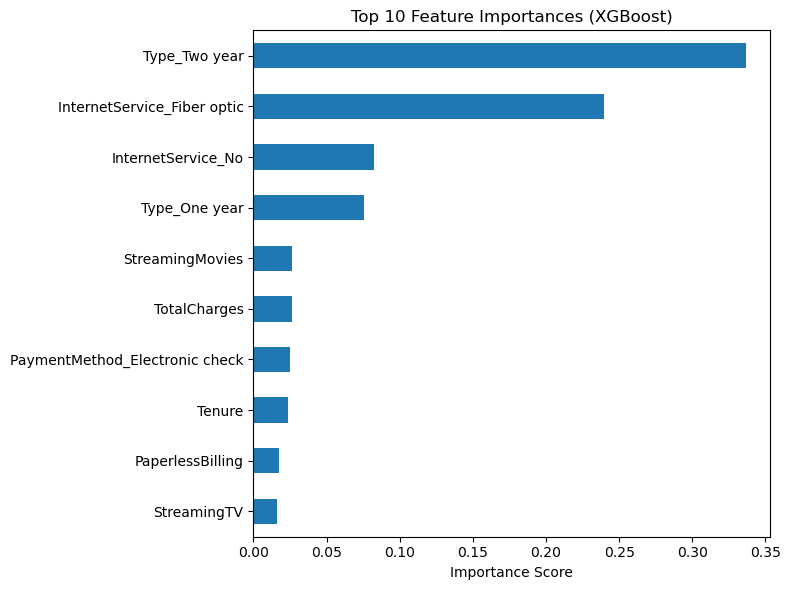

In [127]:
# Plot
plt.figure(figsize=(8, 6))
top_features.plot(kind='barh')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Feature Importance (XGBoost)

The plot above shows the top 10 most important features used by the XGBoost model to predict customer churn.

### Key Insights
- **Contract Type (`Type_Two year` and `Type_One year`)** are the most influential predictors. Customers with longer-term contracts are significantly less likely to churn.
- **Internet service type** is also critical — those with **Fiber optic** service are more likely to churn compared to those with **no internet service**.
- **Streaming services** (`StreamingMovies`, `StreamingTV`) and **billing details** like `PaperlessBilling` and `PaymentMethod_Electronic check` contribute to model predictions, though to a lesser extent.
- **Tenure** and `TotalCharges` are meaningful but less dominant than categorical service features.

### Interpretation
The model relies heavily on the **type and level of service engagement** to determine churn risk. Customers with less commitment (e.g., month-to-month contracts) and higher bandwidth services (e.g., Fiber optic) appear more likely to churn, potentially due to cost sensitivity or service satisfaction.

This insight could guide business strategy for targeted retention efforts.

In [129]:
# Calculate correlation matrix with the target included
corr_matrix = df_encoded.corr()

In [130]:
# Focus on features most correlated with Churn
top_corr = corr_matrix['Churn'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = corr_matrix.loc[top_corr, top_corr]

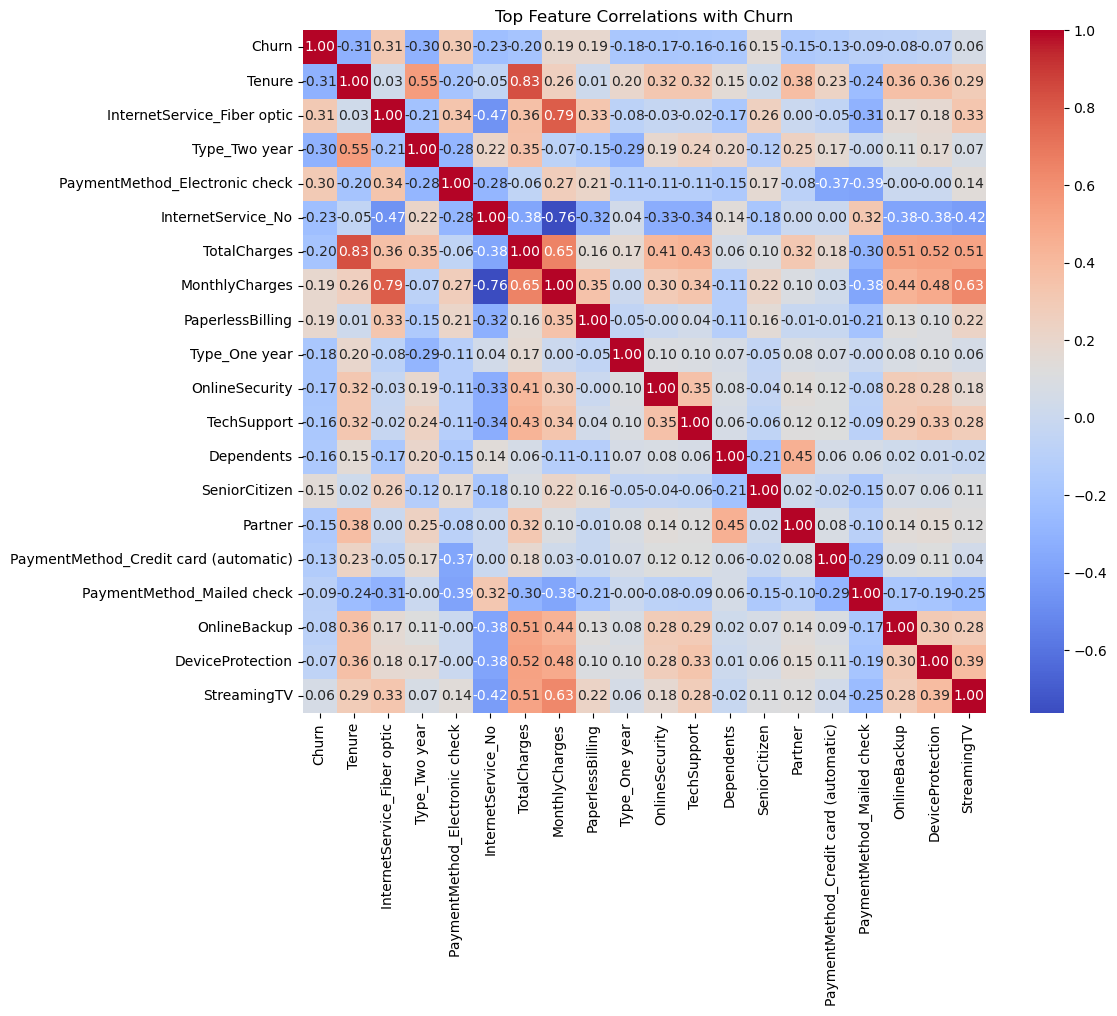

In [131]:
# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Top Feature Correlations with Churn")
plt.tight_layout()
plt.show()

## Correlation Heatmap

The heatmap above displays the pairwise correlations between the top 20 features most correlated with the target variable `Churn`.

### Key Observations:
- `Type_Two year` and `Tenure` have strong **negative correlations** with churn, indicating customers on longer contracts or with higher tenure are far less likely to leave.
- `InternetService_Fiber optic` shows a **positive correlation** with churn, which aligns with earlier feature importance analysis — possibly due to cost or service expectations.
- `PaymentMethod_Electronic check` is moderately correlated with churn, suggesting some payment methods may signal higher risk.
- Binary features like `OnlineSecurity`, `TechSupport`, and `PaperlessBilling` show meaningful relationships and help further validate what the model has learned.
- Some service-related features are moderately correlated with one another (e.g., `StreamingTV` and `StreamingMovies`), which may be worth considering in model regularization or business segmentation.

This visualization complements the feature importance plot and provides further confidence in the selected predictors.

----------

## Final Project Wrap-Up Report

### Project Goal
The objective of this project was to build a predictive model to identify customers likely to churn from Interconnect, a telecom provider. By accurately forecasting churn, the company can proactively offer targeted promotions and retention strategies.

### Data
The dataset consisted of four sources:
- `contract.csv`: Billing and subscription details
- `personal.csv`: Demographic information
- `internet.csv`: Internet service usage
- `phone.csv`: Phone service usage

The datasets were merged on `customerID`, cleaned, and engineered to extract meaningful features for modeling, including binary encoding, tenure calculation, and one-hot encoding of categorical variables.

### Modeling
Five models were evaluated:
- Logistic Regression (baseline)
- Random Forest
- Gradient Boosting
- LightGBM
- XGBoost

### Results

| Model                | AUC-ROC | Accuracy |
|----------------------|---------|----------|
| XGBoost              | **0.9318**  | 89.43%   |
| LightGBM             | 0.9256  | **89.50%**   |
| Gradient Boosting    | 0.9104  | 86.44%   |
| Random Forest        | 0.8741  | 82.82%   |
| Logistic Regression  | 0.8289  | 79.27%   |

### Overfitting Check
To assess model generalization, the final XGBoost model was also evaluated on the training set:

- **Train AUC-ROC:** 0.9997
- **Train Accuracy:** 99.01%

Although training performance was extremely high, the strong test results indicate that the model generalizes well and avoids severe overfitting — a common but manageable trait of gradient boosting models.

### Key Feature Insights

#### Feature Importance
An XGBoost feature importance plot revealed the most influential predictors:
- Contract type (`Type_Two year`, `Type_One year`) was by far the most important indicator of churn.
- `InternetService_Fiber optic` and `InternetService_No` also contributed significantly, indicating that service level and access are tied closely to churn behavior.
- Additional factors like `StreamingMovies`, `PaperlessBilling`, `Tenure`, and `TotalCharges` added valuable predictive power.

These findings reinforce the idea that customers on flexible, high-cost plans (e.g., Fiber optic, month-to-month contracts) are more likely to churn.

#### Correlation Analysis
A correlation heatmap was used to explore the relationships between features and with the target variable `Churn`. Notable patterns included:
- Strong **negative correlation** between churn and both `Tenure` and `Type_Two year`, confirming that long-term customers are less likely to leave.
- **Positive correlation** between churn and `InternetService_Fiber optic` and `PaymentMethod_Electronic check`, suggesting that certain payment methods and service types may signal risk.
- Moderate correlations were observed between related service features (e.g., `StreamingTV` and `StreamingMovies`), indicating potential multicollinearity.

Together, the feature importance and correlation analyses validated the model's top predictors and provided deeper insight into customer churn behavior.

## Conclusion

This project successfully built and evaluated multiple models to predict customer churn using a combination of contract and service usage data. After testing a range of models, XGBoost delivered the best balance of performance and interpretability, with an AUC-ROC of **0.9318** and an accuracy of **89.43%**.

Through this process, it became clear that contract length and internet service type are the strongest predictors of churn. These findings can be used by Interconnect's marketing and retention teams to prioritize outreach and improve customer loyalty.